In [1]:
import os
import pandas as pd                             # csv
import numpy as np
import spacy                                    # nlp
import torch
from torch.nn.utils.rnn import pad_sequence     # sequence padding
from torch.utils.data import DataLoader, Dataset
from PIL import Image                           # image
import torch.nn as nn
import torchvision.models as models             # inception v3
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Building vocabulary from the dataset
spacy_eng = spacy.load('en_core_web_sm')
class Vocabulary:
    def __init__(self, freq_threshold):
        self.idx2str = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UKN>'} # UKN - unknown, if a word has freq less than threshold then it is mapped to UKN
        self.str2idx = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UKN>':3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.idx2str)

    @staticmethod
    def tokenizer_eng(text):
        return [i.text.lower() for i in spacy_eng.tokenizer(text)]
        #above converts 'My Name is' to ['my', 'name', 'is']

    def build_vocabulary(self, sentence_list):
        freq = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in freq:
                    freq[word] = 1
                else:
                    freq[word] += 1

                if freq[word] == self.freq_threshold:
                    self.str2idx[word] = idx
                    self.idx2str[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.str2idx[token] if token in self.str2idx else self.str2idx['<UKN>']
            for token in tokenized_text
        ]
        # above return respective index for word if above threshold else return 3 - <UKN>

In [3]:
# Accessing the dataset and pre-processing images and captions as per requirement
class model_data(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=1):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        self.imgs = self.df['image']
        self.captions = self.df['caption']

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        caption2int = [self.vocab.str2idx["<SOS>"]]
        caption2int += self.vocab.numericalize(caption)
        caption2int.append(self.vocab.str2idx['<EOS>'])

        return img, torch.tensor(caption2int)

In [4]:
# Padding the sequence for equal length of inputs using this function instead of default collate function as concat of images and text is absent in default function
class pad_seq:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [5]:
# splitting and creating datasets
def get_loader(root_folder, csv_file, transform): #batch_size=32, num_workers=8, shuffle=True):
    dataset = model_data(root_folder, csv_file, transform=transform)
    pad_idx = dataset.vocab.str2idx['<PAD>']
    total_count = len(dataset)
    print(total_count)
    train_count = int(0.8 * total_count)
    print(train_count)
    valid_count = int(0.1 * total_count)
    print(valid_count)
    test_count = total_count - train_count - valid_count
    print(test_count)
    train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_count, valid_count, test_count))
    # loader = DataLoader(dataset=dataset,
    #                     batch_size=batch_size,
    #                     num_workers=num_workers,
    #                     shuffle=shuffle,
    #                     collate_fn=pad_seq(pad_idx=pad_idx))
    return dataset, train_dataset, valid_dataset, test_dataset, pad_idx

In [6]:
class Encoder_CNN(nn.Module):
    def __init__(self, embed_dim, train_CNN=False):
        super(Encoder_CNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_dim)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        with torch.no_grad():
            features = self.inception(images)
        return self.dropout(self.relu(features))

In [7]:
class Decoder_RNN(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, n_layers):
        super(Decoder_RNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        # concatenate output features of image with caption embeddings
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hidden, _ = self.lstm(embeddings)
        output = self.linear(hidden)
        return output

In [8]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, n_layers):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = Encoder_CNN(embed_dim)
        self.decoderRNN = Decoder_RNN(embed_dim, hidden_dim, vocab_size, n_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        output = self.decoderRNN(features, captions)
        return output

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0) # unsqueeze for batch size
            states = None # states for lstm

            for _ in range(max_length):
                hidden, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hidden.squeeze(0))
                predicted = output.argmax(1)

                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.idx2str[predicted.item()] == '<EOS>':
                    break
        return [vocabulary.idx2str[idx] for idx in result_caption]

In [9]:
loss_track = []
def train(model, train_loader, valid_loader, dataset, epochs=5, lr=0.001, print_every=25):

    train_CNN = False
    counter = 0
    
    loss_func = nn.CrossEntropyLoss(ignore_index=dataset.vocab.str2idx['<PAD>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # To train whole model or just fine tune to our need
    for name, param in model.encoderCNN.inception.named_parameters():
            if 'fc.weight' in name or 'fc.bias' in name:
                param.requires_grad = True
            else:
                param.requires_grad = train_CNN

    model.train()
    for epoch in (range(epochs)):
        for idx, (imgs, captions) in enumerate(train_loader):#, total=len(train_loader), leave=False):
            counter += 1

            output = model(imgs, captions[:-1])
            # output -> [seq_len, N, vocab_size], for loss -> [seq_len*N, vocab_size]
            loss = loss_func(output.reshape(-1, output.shape[2]), captions.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_track.append(loss.item())
            
            # loss stats
            if counter%print_every == 0:
                val_losses = []
                model.eval()
                for idx, (imgs, captions) in enumerate(valid_loader):#, total=len(valid_loader), leave=False):
                    output = model(imgs, captions[:-1])
                    val_loss = loss_func(output.reshape(-1, output.shape[2]), captions.reshape(-1))
                    val_losses.append(val_loss.item())
                model.train()
                print('Epoch: {}/{}...'.format(epoch+1, epochs),
                      'Step: {}...'.format(counter),
                      'Loss: {:.6f}...'.format(loss.item()),
                      'Valid_loss: {:.6f}...'.format(np.mean(val_losses)))

In [10]:
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)), # this specific dim used cuz same used in paper
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

dataset, train_dataset, valid_dataset, test_dataset, pad_idx = get_loader(r"E:\img_captioning_data\flickr8k\images_test",
                                                                          r"E:/img_captioning_data/flickr8k/captions_test.txt",
                                                                          transform=transform)

50
40
5
5


In [11]:
# Hyperparameters
embed_dim = 256
hidden_dim = 256
vocab_size = len(dataset.vocab)
n_layers = 2
lr = 0.001
print_every = 20
epochs = 50
batch_size = 2

In [12]:
# Data loaders
train_loader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    collate_fn=pad_seq(pad_idx=pad_idx))

valid_loader = DataLoader(dataset=valid_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    collate_fn=pad_seq(pad_idx=pad_idx))

test_loader = DataLoader(dataset=test_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    collate_fn=pad_seq(pad_idx=pad_idx))

In [13]:
model = CNN2RNN(embed_dim, hidden_dim, vocab_size, n_layers)
print(model)

CNN2RNN(
  (encoderCNN): Encoder_CNN(
    (inception): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=T

In [14]:
train(model, train_loader, valid_loader, dataset, epochs=epochs, lr=lr, print_every=print_every)

Epoch: 1/50... Step: 20... Loss: 4.567641... Valid_loss: 4.775859...
Epoch: 2/50... Step: 40... Loss: 4.389285... Valid_loss: 4.585564...
Epoch: 3/50... Step: 60... Loss: 4.089845... Valid_loss: 4.488102...
Epoch: 4/50... Step: 80... Loss: 3.918598... Valid_loss: 4.451128...
Epoch: 5/50... Step: 100... Loss: 2.985101... Valid_loss: 4.357591...
Epoch: 6/50... Step: 120... Loss: 2.478770... Valid_loss: 4.038241...
Epoch: 7/50... Step: 140... Loss: 2.521892... Valid_loss: 3.978059...
Epoch: 8/50... Step: 160... Loss: 2.104608... Valid_loss: 4.159768...
Epoch: 9/50... Step: 180... Loss: 1.637854... Valid_loss: 3.997078...
Epoch: 10/50... Step: 200... Loss: 1.636634... Valid_loss: 4.287665...
Epoch: 11/50... Step: 220... Loss: 1.626146... Valid_loss: 4.108763...
Epoch: 12/50... Step: 240... Loss: 1.358522... Valid_loss: 4.126743...
Epoch: 13/50... Step: 260... Loss: 0.866801... Valid_loss: 4.284659...
Epoch: 14/50... Step: 280... Loss: 1.249933... Valid_loss: 4.102302...
Epoch: 15/50... Ste

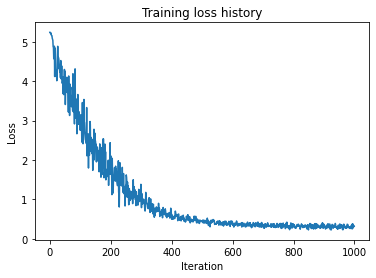

In [21]:
# Plot the training losses
plt.plot(range(len(loss_track)), loss_track)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

####  Due to computational limitaion, I have trained this model on a dataset of 10 images for 50 epochs. We can observe that as we are overfitting the model over 10 images, we achieve a loss that is less than 0.5.  We can infer from the above graph that the model is working fine and with the model trained over the whole dataset for sufficient amount of epochs, good accuracy will be achieved.